In [1]:
import pandas as pd
import pickle
from sportsreference.ncaab.teams import Teams
from sportsreference.ncaab.conferences import Conferences
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random as rnd
from utils import  score_table
import importlib
from datetime import datetime

#import argparse

import torch
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Predictive, Trace_ELBO
from pyro.optim import ClippedAdam
from torch.distributions import constraints

In [2]:
majorConfs = ["big-12","Big 12",
              "big-10","Big Ten","big-ten",
              "sec","SEC",
              "big-east","Big East",
              "pac-12","Pac-12",
              "acc","ACC",
              "wcc", "WCC",
              "mwc","MWC",
              "atlantic-10","Atlantic 10"]
confNameNorm = {"Big 12":"big-12",
              "Big Ten":"big-ten",
              "big-ten":"big-ten",
              "SEC":"sec",
              "Big East":"big-east",
              "Pac-12":"pac-12",
              "ACC":"acc",
              "WCC":"wcc",
                "MWC":"mwc",
               "Atlantic 10":"atlantic-10"}
def getDataForTeams(teams) :
    dataset = pd.DataFrame()
    for team in teams:
        if team.conference in majorConfs:
            tgDF = team.schedule.dataframe
            tgDF['team_name'] = team.name
            tgDF['team_conference'] = team.conference
            dataset = pd.concat([dataset,tgDF])     
    return dataset


In [3]:
#execute this cell to grab the data from the site
#season_team_list = Teams("2022")
#df = getDataForTeams(season_team_list)
#compression_opts = dict(method='zip',
#                        archive_name='outv3.csv')  
#df.to_csv('data/bigconfs2022Season.zip', compression=compression_opts) 
#pickle.dump( season_team_list, open( "data/teams2022.p", "wb" ) )

In [4]:
#execute this cell to just load the local files
season_team_list = pickle.load( open( "data/teams2022.p", "rb" ) )
c_opts = dict(method='zip')
df = pd.read_csv('data/bigconfs2022Season.zip',compression='zip')

In [6]:
df.opponent_conference.unique()
allConfs = []
for team in season_team_list:
    allConfs.append(team.conference)
set(allConfs)

{'aac',
 'acc',
 'america-east',
 'atlantic-10',
 'atlantic-sun',
 'big-12',
 'big-east',
 'big-sky',
 'big-south',
 'big-ten',
 'big-west',
 'colonial',
 'cusa',
 'horizon',
 'ivy',
 'maac',
 'mac',
 'meac',
 'mvc',
 'mwc',
 'northeast',
 'ovc',
 'pac-12',
 'patriot',
 'sec',
 'southern',
 'southland',
 'summit',
 'sun-belt',
 'swac',
 'wac',
 'wcc'}

In [8]:
def transformData(data):
    pl_data = data

    ng = len(pl_data)  # number of games
    npr = 45  # predict the last 5 rounds of games
    ngob = ng - npr  # number of games to train

    pl_data = pl_data.rename(columns={"FTHG": "score1","FTAG":"score2",
                            "HomeTeam":"Home","AwayTeam":"Away"})

    #teams = pl_data["Home"].unique()
    teams = list(set(pl_data.Home.unique().tolist()).union(set(pl_data.Away.unique().tolist())))
    teams = pd.DataFrame(teams, columns=["Team"])
    teams["i"] = teams.index

    df = pd.merge(pl_data, teams, left_on="Home", right_on="Team", how="left")
    df = df.rename(columns={"i": "Home_id"}).drop("Team", axis=1)
    df = pd.merge(df, teams, left_on="Away", right_on="Team", how="left")
    df = df.rename(columns={"i": "Away_id"}).drop("Team", axis=1)

    print(df.head())

    return teams, df

def replicateSwappingHomeAndAway(df):
    cdf = df.copy()
    swapdf = pd.DataFrame(columns=['Date','HomeTeam','AwayTeam','FTHG','FTAG'])

    swapdf['Date'] = cdf.Date
    swapdf['HomeTeam'] = cdf.AwayTeam
    swapdf['AwayTeam'] = cdf.HomeTeam
    swapdf['FTHG'] = cdf.FTAG
    swapdf['FTAG'] = cdf.FTHG
    
    fdf = pd.concat([cdf,swapdf], axis=0)
    fdf.reset_index(inplace=True, drop=True)
    return fdf

foo = pd.DataFrame({'Date':['monday','tuesday'],
                    'HomeTeam':['msu','uw'],
                    'AwayTeam':['um','purdue'],
                    'FTHG':[99,88],
                    'FTAG':[25,75]})
foobar = replicateSwappingHomeAndAway(foo)
#foobar


In [9]:
class FoldedTransform(dist.transforms.AbsTransform):
    def log_abs_det_jacobian(self, x, y):
        return torch.zeros_like(x)

def model(home_id, away_id, score1_obs=None, score2_obs=None):
    # hyperpriors
    alpha = pyro.sample("alpha", dist.Normal(0.0, 1.0))
    sd_att = pyro.sample("sd_att", dist.TransformedDistribution(dist.StudentT(3.0, 0.0, 4), FoldedTransform()))
    sd_def = pyro.sample("sd_def", dist.TransformedDistribution(dist.StudentT(3.0, 0.0, 4), FoldedTransform()))
    #student t: degrees of freedom, mean, width
    #started with width = 2.5
    #home = pyro.sample("home", dist.Normal(0.0, 2.0))  # home advantage
    #started with 1.0 for std

    #this has to be the number of teams!!! 
    #nt = len(np.unique(home_id))
    nt = len(list(set(np.unique(home_id).tolist()).union(set(np.unique(away_id).tolist()))))


    # team-specific model parameters
    with pyro.plate("plate_teams", nt):
        attack = pyro.sample("attack", dist.Normal(0, sd_att))
        defend = pyro.sample("defend", dist.Normal(0, sd_def))

    # likelihood
    theta1 = torch.exp(alpha + attack[home_id] - defend[away_id])
    theta2 = torch.exp(alpha + attack[away_id] - defend[home_id])

    with pyro.plate("data", len(home_id)):
        pyro.sample("s1", dist.Poisson(theta1), obs=score1_obs)
        pyro.sample("s2", dist.Poisson(theta2), obs=score2_obs)

def guide(home_id, away_id, score1_obs=None, score2_obs=None):
    mu_locs = pyro.param("mu_loc", torch.tensor(0.0).expand(3))
    mu_scales = pyro.param("mu_scale", torch.tensor(0.1).expand(3), constraint=constraints.positive)

    pyro.sample("alpha", dist.Normal(mu_locs[0], mu_scales[0]))
    pyro.sample("sd_att", dist.LogNormal(mu_locs[1], mu_scales[1]))
    pyro.sample("sd_def", dist.LogNormal(mu_locs[2], mu_scales[2]))
    #pyro.sample("home", dist.Normal(mu_locs[3], mu_scales[3]))  # home advantage

    nt = len(list(set(np.unique(home_id).tolist()).union(set(np.unique(away_id).tolist()))))
    #nt = len(np.unique(home_id))
    #print("number of teams: ", nt)

    mu_team_locs = pyro.param("mu_team_loc", torch.tensor(0.0).expand(2, nt))
    mu_team_scales = pyro.param("mu_team_scale", torch.tensor(0.1).expand(2, nt), constraint=constraints.positive)

    with pyro.plate("plate_teams", nt):
        pyro.sample("attack", dist.Normal(mu_team_locs[0], mu_team_scales[0]))
        pyro.sample("defend", dist.Normal(mu_team_locs[1], mu_team_scales[1]))

def run_inference(model, guide, home_id, away_id, score1, score2, args):
    gamma = 0.01  # final learning rate will be gamma * initial_lr
    lrd = gamma ** (1 / args.num_iterations)

    svi = SVI(
        model=model,
        guide=guide,
        optim=ClippedAdam({"lr": args.learning_rate, "lrd": lrd}),
        loss=Trace_ELBO(num_particles=args.num_particles),
    )

    pyro.clear_param_store()  # clear global parameter cache
    pyro.set_rng_seed(args.rng_seed)

    advi_loss = []
    for j in range(args.num_iterations):
        # calculate the loss and take a gradient step
        loss = svi.step(
            home_id=home_id,
            away_id=away_id,
            score1_obs=score1.float(),
            score2_obs=score2.float(),
        )
        advi_loss.append(loss)
        if j % 100 == 0:
            print("[iteration %4d] loss: %.4f" % (j + 1, loss))

    print("Posterior: ")
    for i in pyro.get_param_store().items():
        print(i)

    fit = Predictive(model=model, guide=guide, num_samples=2000)(
        home_id=home_id, away_id=away_id
    )

    return fit

def runThePyroFit(data,args,predictDF):
    print("transforming data...")
    teams, df =  transformData(data)
    #train = df[df["split"] == "train"]
    train = df

    print("Starting inference...")
    fit = run_inference(
        model,
        guide,
        torch.tensor(train["Home_id"]),
        torch.tensor(train["Away_id"]),
        torch.tensor(train["score1"]),
        torch.tensor(train["score2"]),
        args,
    )

    print("Analyse posterior...")

    quality = teams.copy()

    quality = quality.assign(
        attack=fit["attack"].mean(axis=0),
        attacksd=fit["attack"].std(axis=0),
        defend=fit["defend"].mean(axis=0),
        defendsd=fit["defend"].std(axis=0),
    )
    quality = quality.assign(
        attack_low=quality["attack"] - quality["attacksd"],
        attack_high=quality["attack"] + quality["attacksd"],
        defend_low=quality["defend"] - quality["defendsd"],
        defend_high=quality["defend"] + quality["defendsd"],
    )

    # Predicted goals and table
    #predict = df[df["split"] == "predict"]
    predict = predictDF
    #print("this many home_ids: " , predict.Home_id.unique())

    predictive = Predictive(
        model=model, guide=guide, num_samples=1000, return_sites=["s1", "s2"]
    )
 
    predicted_scores = predictive(
        home_id=predict["Home_id"].values,
        away_id=predict["Away_id"].values,
    )

    return(predicted_scores,quality)

def getTeamIndex(ts,name):
    return(ts[ts['Team']==name].i.values[0])
def getGameIndexs(ts,name1,name2):
    return([getTeamIndex(ts,name1),getTeamIndex(ts,name2)])

def getScoresIthGame(g,mIterByGames):
    #loop thru games
    scores=[]
    for i in range(len(mIterByGames)):
        scores.append(mIterByGames[i][g].tolist())
    return(scores)

#[len(predicted_scores["s1"]),len(predicted_scores["s1"][0]),len(tt.index)]
# iteration X games

#predicted_scores["s1"][0][0].tolist()

#predicted_scores["s1"]


In [10]:
df = pd.read_csv('data/bigconfs2022Season.zip',compression='zip')
#keepConfs = majorConfs
keepConfs = ["big-10","Big Ten","big-ten",
            "big-12","Big 12",
            "sec","SEC",
              "big-east","Big East",
              "pac-12","Pac-12"]
keepConfs = ["big-10","Big Ten","big-ten",
            "big-12","Big 12",
              "big-east","Big East",
              "acc","ACC",
            "pac-12","Pac-12"]

dformat = '%a, %b %d, %Y'
keepGreaterThanDate = datetime.strptime('Tue, Dec 31, 2021', dformat)

bdf = df.copy()


#only keep games after this date
bdf['date'] = pd.to_datetime(bdf['date'], format=dformat)
bdf = bdf[bdf.date > keepGreaterThanDate]


#only have games between big conferences
bdf = bdf[(bdf["opponent_conference"].isin(keepConfs)) & 
         (bdf["team_conference"].isin(keepConfs)) ]

#get rid of duplicates
bdf.drop_duplicates(subset='boxscore_index', keep="first")
#drop Neutral games for now
ndf = bdf[bdf["location"] == 'Neutral']
bdf = bdf[bdf["location"].isin(["Home","Away"])]

#create Home, Away, neutral indicator columns
bdf = pd.get_dummies(bdf,prefix=['location'], columns = ['location'])
#create homeTeam, awayTeam columns
def addHomeTeamColumn(row):
    if(row['location_Home'] == 1):
        return row['team_name']
    else:
        return row['opponent_name']
bdf['HomeTeam'] = bdf.apply(addHomeTeamColumn, axis=1)
def addAwayTeamColumn(row):
    if(row['location_Away'] == 1):
        return row['team_name']
    else:
        return row['opponent_name']
bdf['AwayTeam'] = bdf.apply(addAwayTeamColumn, axis=1)
#add in "HomePoints" , AwayPoints
def addHomePointsColumn(row):
    if(row['location_Home'] == 1):
        return row['points_for']
    else:
        return row['points_against']
bdf['HomePoints'] = bdf.apply(addHomePointsColumn, axis=1)
def addAwayPointsColumn(row):
    if(row['location_Away'] == 1):
        return row['points_for']
    else:
        return row['points_against']
bdf['AwayPoints'] = bdf.apply(addAwayPointsColumn, axis=1)

#neutral games; double them with swapped home and away
selector_neut = {'date':'Date', 'team_name':'HomeTeam', 'opponent_name':'AwayTeam',
              'points_for':'FTHG', 'points_against':'FTAG'}
ndf = ndf.rename(columns=selector_neut)[selector_neut.values()]
ndf.reset_index(inplace=True,drop=True)
ndfd = replicateSwappingHomeAndAway(ndf)



#just big ten conference games
big10df = bdf.loc[(bdf["team_conference"]=='big-ten')&
                  (bdf['opponent_conference']=='Big Ten')]

#rename columns
selector_d = {'date':'Date', 'HomeTeam':'HomeTeam', 'AwayTeam':'AwayTeam',
              'HomePoints':'FTHG', 'AwayPoints':'FTAG'}
bdf = bdf.rename(columns=selector_d)[selector_d.values()]
bdf.reset_index(inplace=True, drop=True)
big10df = big10df.rename(columns=selector_d)[selector_d.values()]
big10df.reset_index(inplace=True, drop=True)

bdfd = replicateSwappingHomeAndAway(bdf)
big10dfd = replicateSwappingHomeAndAway(big10df)
bdfplusN = pd.concat([bdf,ndf],axis=0)
bdfplusN.reset_index(inplace=True, drop=True)

#bdf.head()




In [11]:
tt,dd = transformData(bdf)

        Date                 Home           Away  score1  score2  Home_id  \
0 2022-01-02           California  Arizona State    74.0    50.0       52   
1 2022-01-15        Arizona State       Colorado    57.0    75.0       55   
2 2022-01-17        Arizona State           Utah    64.0    62.0       55   
3 2022-01-22             Stanford  Arizona State    79.0    76.0       31   
4 2022-01-24  Southern California  Arizona State    78.0    56.0       61   

   Away_id  
0       55  
1       59  
2       16  
3       55  
4       55  


In [15]:
pd. set_option('display.max_rows', 1000) # or None
tt

,Team,i
0,North Carolina,0
1,Georgetown,1
2,NC State,2
3,Creighton,3
4,Oklahoma,4
5,Penn State,5
6,West Virginia,6
7,DePaul,7
8,Notre Dame,8
9,Georgia Tech,9


In [16]:
tt,dd = transformData(bdf)
tsn = ['Southern California',"Miami (FL)"]
ts = getGameIndexs(tt,tsn[0],tsn[1])
#tsn2 = ['Kansas',"Rutgers"]
#ts2 = getGameIndexs(teams,tsn2[0],tsn2[1])
allTeams = list(tt.i)              
AvB = pd.DataFrame({'Home_id':[ts[0]]+allTeams,
        'Away_id':[ts[1]]+allTeams})
class Args():
    learning_rate = 0.1
    num_particles = 1
    rng_seed = 1
    num_iterations = 2000
args=Args()

(predicted_scores,qDF) = runThePyroFit(bdf,args,AvB)

        Date                 Home           Away  score1  score2  Home_id  \
0 2022-01-02           California  Arizona State    74.0    50.0       52   
1 2022-01-15        Arizona State       Colorado    57.0    75.0       55   
2 2022-01-17        Arizona State           Utah    64.0    62.0       55   
3 2022-01-22             Stanford  Arizona State    79.0    76.0       31   
4 2022-01-24  Southern California  Arizona State    78.0    56.0       61   

   Away_id  
0       55  
1       59  
2       16  
3       55  
4       55  
transforming data...
        Date                 Home           Away  score1  score2  Home_id  \
0 2022-01-02           California  Arizona State    74.0    50.0       52   
1 2022-01-15        Arizona State       Colorado    57.0    75.0       55   
2 2022-01-17        Arizona State           Utah    64.0    62.0       55   
3 2022-01-22             Stanford  Arizona State    79.0    76.0       31   
4 2022-01-24  Southern California  Arizona State    7

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'defend strength')

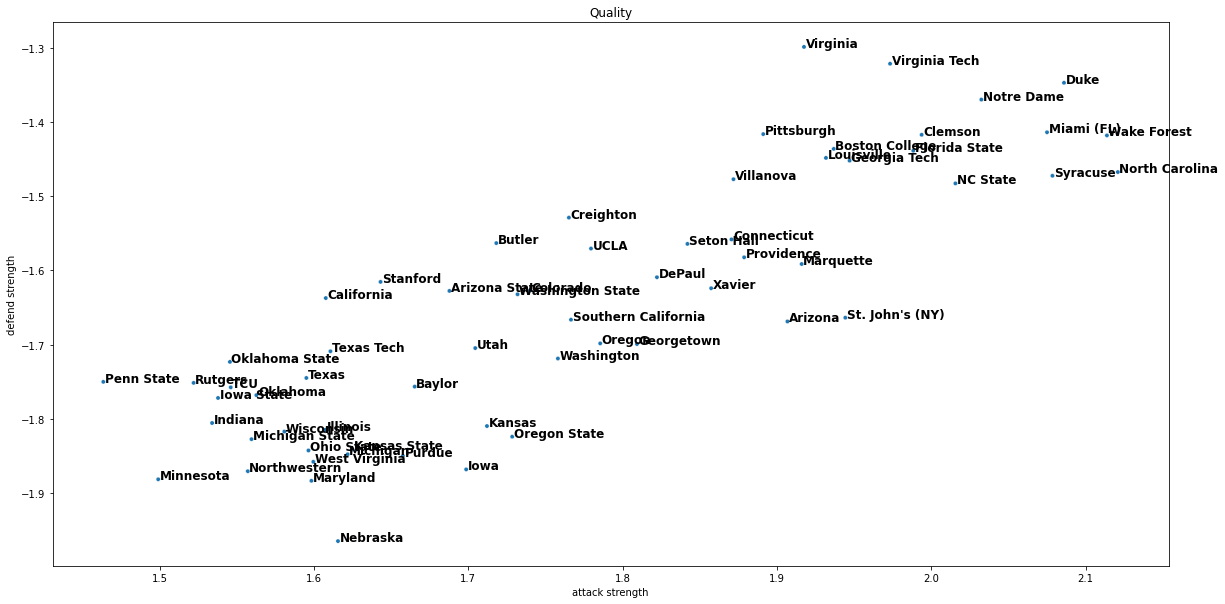

In [17]:
plt.figure(figsize=(20,10))
p1 = sns.scatterplot('attack', # Horizontal axis
       'defend', # Vertical axis
       data=qDF, # Data source
       size = 8,
       legend=False)  

for line in range(0,qDF.shape[0]):
     p1.text(qDF.attack[line]+0.001, qDF.defend[line], 
     qDF.Team[line], horizontalalignment='left', 
     size='large', color='black', weight='semibold')

plt.title('Quality')
# Set x-axis label
plt.xlabel('attack strength')
# Set y-axis label
plt.ylabel('defend strength')

In [18]:

t1scores = getScoresIthGame(0,predicted_scores["s1"])
t2scores = getScoresIthGame(0,predicted_scores["s2"])

#spread and over under distributions
n=500
sams1=rnd.choices(t1scores, k=n)
sams2=rnd.choices(t2scores, k=n)
overunder = [p1+p2 for p1 in sams1 for p2 in sams2]
spread    = [p1-p2 for p1 in sams1 for p2 in sams2]
samsDF = pd.DataFrame({'overunder':overunder,'spread':spread})


Text(0.5, 1.0, 'blue:Southern California green:Miami (FL)')

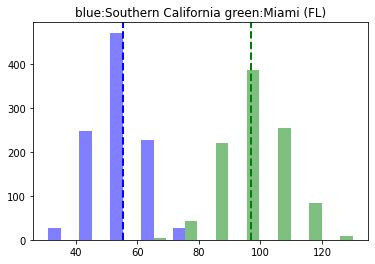

In [19]:

def meanl(lst):
    return sum(lst) / len(lst)
plt.hist([t1scores, t2scores], color=['b','g'], alpha=0.5)
plt.axvline(meanl(t1scores), color='b', linestyle='dashed', linewidth=2)
plt.axvline(meanl(t2scores), color='g', linestyle='dashed', linewidth=2)
plt.title("blue:"+tsn[0]+" green:"+tsn[1])


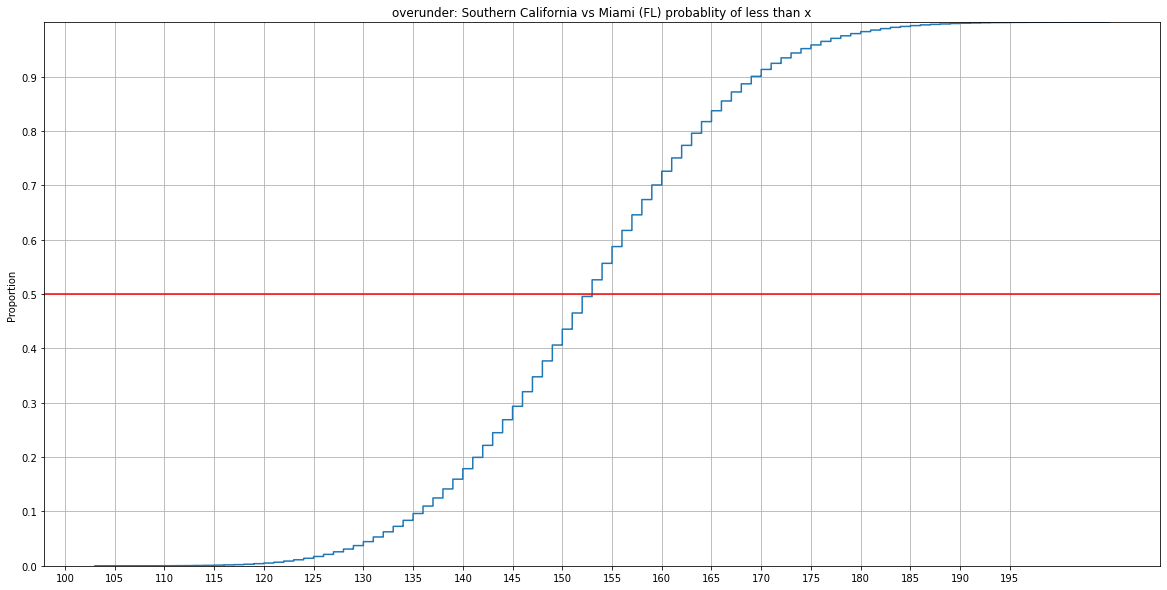

In [20]:
plt.figure(figsize=(20,10))

sns.ecdfplot(overunder)
plt.grid()
plt.xticks(range(100,200,5))
plt.yticks([a/10.0 for a in range(0,10)])
plt.axhline(y=0.5, color='r', linestyle='-')
plt.title("overunder: "+tsn[0]+" vs "+tsn[1]+" probablity of less than x")
plt.savefig('figs/'+tsn[0]+"vs"+tsn[1]+"Overunder.png")

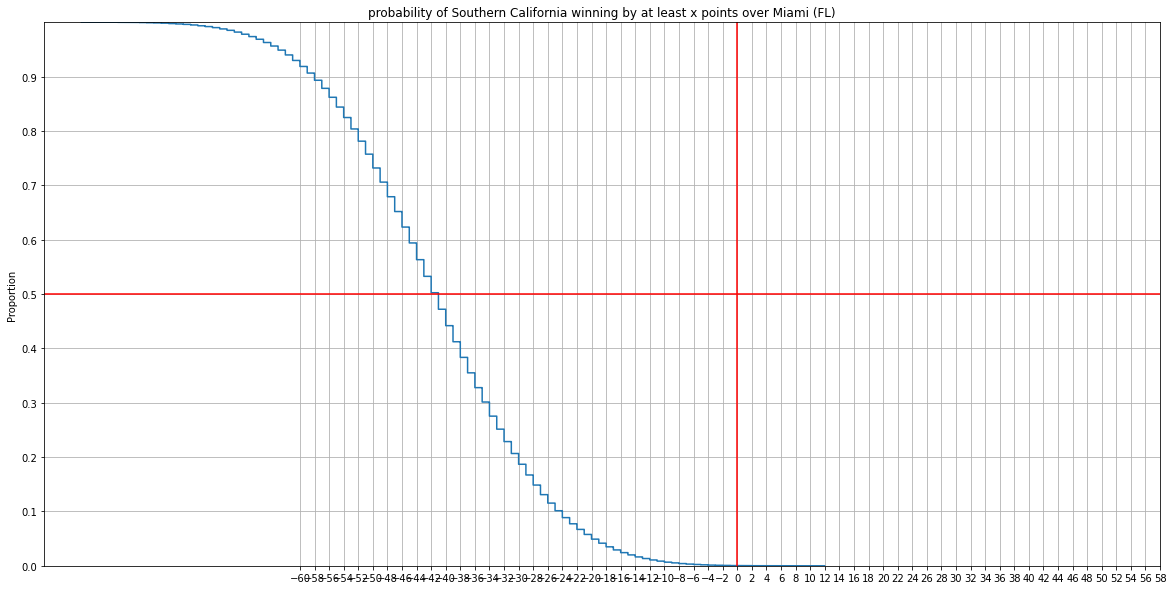

In [21]:
#probability of team1 wining by at least x points
plt.figure(figsize=(20,10))

sns.ecdfplot(spread,complementary=True)
plt.grid()
plt.xticks(range(-60,60,2))
plt.yticks([a/10.0 for a in range(0,10)])
plt.title("probability of "+ tsn[0] + " winning by at least x points over "+tsn[1])

plt.axhline(y=0.5, color='r', linestyle='-')
plt.axvline(x=0, color='r', linestyle='-')
plt.savefig('figs/'+tsn[0]+"vs"+tsn[1]+"spread.png")